## Entrada dos dados

In [1]:
import pandas as pd
df = pd.read_csv("./datasets/NAICS_number_of_orders_not_seasonally_ajusted.csv")
df.head(3)

,DATA,DEMANDA
0,01/01/1992,20532164
1,01/02/1992,21792493
2,01/03/1992,23948450


In [2]:
datas = df['DATA'].values
dados = df.drop(columns=['DATA'])
dados = dados['DEMANDA'].tolist()

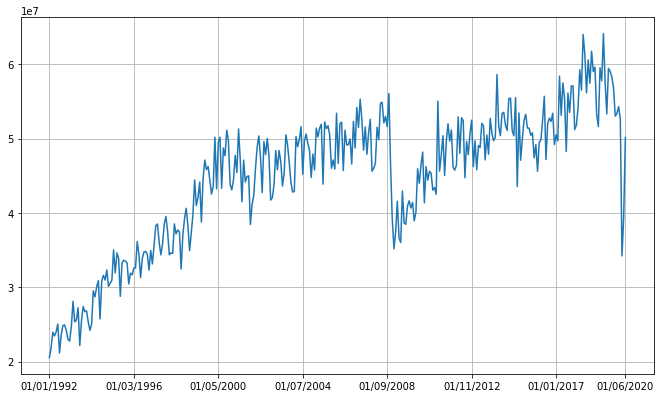

In [3]:
import matplotlib.pyplot as plt

ticks = []
indice_grafico = []
for i in (range(0, len(datas), 50)):
    indice_grafico.append(datas[i])
    ticks.append(i)
indice_grafico.append(datas[len(datas)-1])
ticks.append(len(datas)-1)

fig, axs = plt.subplots(1, figsize=(11, 5.5))
axs.plot(dados)
axs.set_xticks(ticks)
axs.set_xticklabels(indice_grafico)
axs.yaxis.grid(True)
axs.xaxis.grid(True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05)
plt.rcParams.update({'font.size': 10})
plt.show()

[0.         0.02889657 0.07832792]


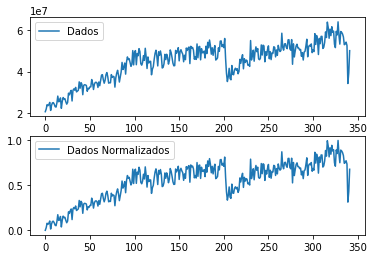

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

dados_escalados = np.array(dados).reshape(-1, 1)
escalador = MinMaxScaler(feature_range=(0, 1))
dados_escalados = escalador.fit_transform(dados_escalados)
dados_escalados = dados_escalados.ravel()
print(dados_escalados[0:3])

fig, axs = plt.subplots(2)
axs[0].plot(dados, label='Dados')
axs[0].legend()
axs[1].plot(dados_escalados, label='Dados Normalizados')
axs[1].legend()
plt.show()

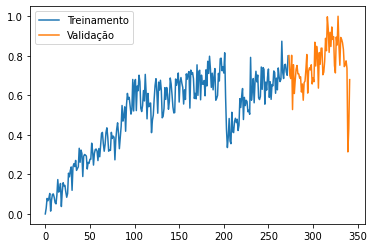

In [5]:
percent_treino = 0.8 # ex: 0.8 = linha do 80%
n_linhas = int(percent_treino * len(dados_escalados))

x_treinar = dados_escalados[:n_linhas]
x_validar = dados_escalados[n_linhas:]

indice_grafico_treinar = datas[:n_linhas]
indice_grafico_validar = datas[n_linhas:]

x_treinar_index = range(0, len(x_treinar))
x_validar_index = range(len(x_treinar), len(x_treinar)+len(x_validar))
plt.plot(x_treinar_index, x_treinar, label='Treinamento')
plt.plot(x_validar_index, x_validar, label='Validação')
plt.legend()
plt.show()

In [6]:
def concatenar_tempos_anteriores(t, concat_dados):
    x_concatenado = []
    y_concatenado = []
    diferenca = len(concat_dados)%t
    for i in range(t+diferenca, len(concat_dados)):
        x_concatenado.append(concat_dados[i-t:i])
        y_concatenado.append(concat_dados[i])
    return x_concatenado, y_concatenado

In [7]:
tempos_anteriores = 6

x_treinar_concat, y_treinar_concat = concatenar_tempos_anteriores(tempos_anteriores, x_treinar)
x_validar_concat, y_validar_concat = concatenar_tempos_anteriores(tempos_anteriores, x_validar)

indice_grafico_treinar = indice_grafico_treinar[tempos_anteriores-1:]
indice_grafico_validar = indice_grafico_validar[tempos_anteriores-1:]

## Previsão Ingênua

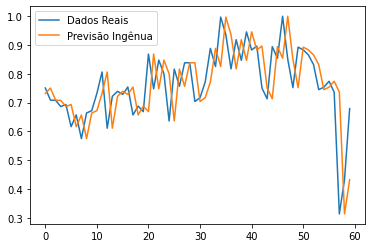

In [8]:
previsao_ingenua = dados_escalados[:-1]
indice_previsoes_classicas = (len(y_validar_concat))*-1
previsao_ingenua = previsao_ingenua[indice_previsoes_classicas:]

plt.plot(y_validar_concat, label='Dados Reais')
plt.plot(previsao_ingenua, label='Previsão Ingênua')
plt.legend()
plt.show()

## Média Móvel Exponencial

In [9]:
def media_movel_exponencial(x, S_inicial, alpha, beta):
    S = S_inicial # Media simples do periodo anterior deve ser o inicial de S
    T = 0 # Tendência para primeira previsão é 0
    y = []

    for i in range (1, len(x)+1):
        A = x[i-1] # Valor real do tempo anterior
        S_anterior = S
        
        S = (alpha * A) + ((1 - alpha) * (S_anterior + T))
        S = round(S, 4)

        T = beta * (S - S_anterior) + (1 - beta) * T
        T = round(T, 4)
        
        F = S + T
        F = round(F, 4)
        
        y.append(F)
    
    return y

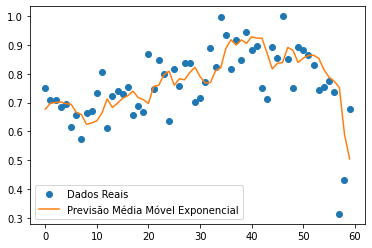

In [10]:
# Envia ultimo registro do periodo anterior mais todos a serem previstos
x_media_movel = dados_escalados[12:-1]
# Média do primeiro ano
s_inicial = np.average(dados_escalados[:12])
previsao_mme = media_movel_exponencial(x_media_movel, s_inicial, 0.3, 0.15)
previsao_mme = previsao_mme[indice_previsoes_classicas:]

plt.plot(y_validar_concat, 'o', label='Dados Reais')
plt.plot(previsao_mme, label='Previsão Média Móvel Exponencial')
plt.legend()
plt.show()

## Regressão Linear

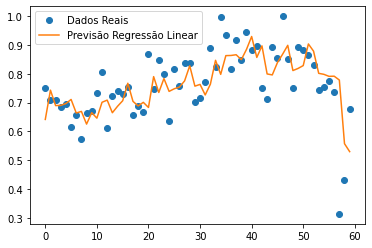

In [11]:
from sklearn.linear_model import LinearRegression
modelo_regressao = LinearRegression()
modelo_regressao.fit(x_treinar_concat, y_treinar_concat)
previsao_reg_lin = modelo_regressao.predict(x_validar_concat)

plt.plot(y_validar_concat, 'o', label='Dados Reais')
plt.plot(previsao_reg_lin, label='Previsão Regressão Linear')
plt.legend()
plt.show()

## LSTM

In [12]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Define semente aleatória para poder replicar resutlados
#np.random.seed(1234)
#tf.random.set_seed(1234)
# Transforma em 3d
np3d_x_treinar_concat = np.array(x_treinar_concat)
n_aspectos = np3d_x_treinar_concat.shape[1]
np3d_x_treinar_concat = np.reshape(x_treinar_concat,
                                   newshape=(-1, n_aspectos, 1))

np_y_treinar_concat = np.array(y_treinar_concat)

In [13]:
from tensorflow.keras.models import load_model
modelo = load_model('./modelos/lstm_multi.h5')

As duas células abaixo estão comentadas porque já estamos carregando o modelo na de cima.
Para gerar um novo, a de cima seria substituída por ambas abaixo

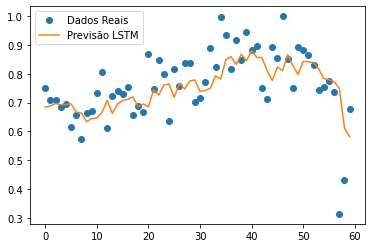

In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Remove avisos de deprecated

np3d_x_validar_concat = np.array(x_validar_concat)
np3d_x_validar_concat = np.reshape(np3d_x_validar_concat,
                                   newshape=(-1,n_aspectos, 1))
previsao_lstm = modelo.predict(np3d_x_validar_concat)

plt.plot(y_validar_concat, 'o', label='Dados Reais')
plt.plot(previsao_lstm, label='Previsão LSTM')
plt.legend()
plt.show()

## Métricas

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def show_metricas(x, y):
    remq = mean_squared_error(escalador.inverse_transform(np.array(x).reshape(-1 ,1)),
                              escalador.inverse_transform(np.array(y).reshape(-1 ,1)),
                              squared=False)
    ema = mean_absolute_error(escalador.inverse_transform(np.array(x).reshape(-1 ,1)),
                              escalador.inverse_transform(np.array(y).reshape(-1 ,1)))
    print('REQM:', round(remq, 2))
    print(' EMA:', round( ema, 2))

print('Ingênua')
show_metricas(previsao_ingenua, y_validar_concat)
print('MME')
show_metricas(previsao_mme, y_validar_concat)
print('Reg. Lin.')
show_metricas(previsao_reg_lin, y_validar_concat)
print('LSTM')
show_metricas(previsao_lstm, y_validar_concat)

Ingênua
REQM: 4852483.51
 EMA: 3637984.07
MME
REQM: 4409680.74
 EMA: 3141941.0
Reg. Lin.
REQM: 4198017.05
 EMA: 2944240.3
LSTM
REQM: 4318740.67
 EMA: 3055164.23


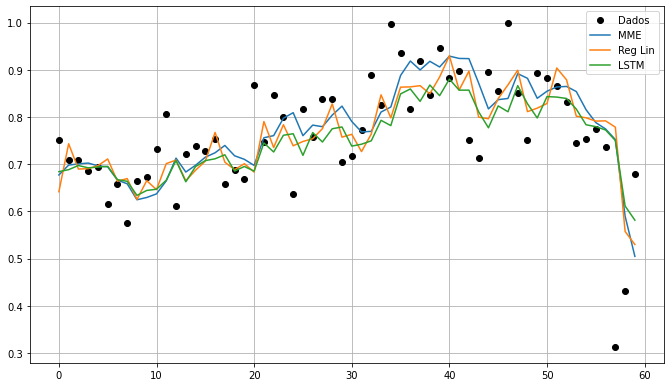

In [19]:
fig, axs = plt.subplots(1, figsize=(11, 5.5))
axs.plot(y_validar_concat, 'ko', label='Dados')
axs.plot(previsao_mme, label='MME')
axs.plot(previsao_reg_lin, label='Reg Lin')
axs.plot(previsao_lstm, label='LSTM')
axs.legend()
axs.yaxis.grid(True)
axs.xaxis.grid(True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05)
plt.rcParams.update({'font.size': 10})
plt.show()